In [13]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import os
import time
import warnings
import numpy as np
from numpy import newaxis
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pyedflib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def load_data(filename):
    g = pyedflib.EdfReader(filename)
    n = g.signals_in_file
    signal_labels = g.getSignalLabels()
    sig = np.zeros((n, g.getNSamples()[0]))
    for i in np.arange(n):
        len_sig = len(g.readSignal(i))
        sig[i, :len_sig] = g.readSignal(i)
    return sig
def make_data(sig, seq_len, normalise_window):
    

    data = sig[0][:500]
    if not normalise_window:
        data = difference(data,1)
    sequence_length = seq_len + 1
    result = np.zeros((len(data) - sequence_length, sequence_length))
    for index in range(len(data) - sequence_length):
        result[index] = data[index: index + sequence_length]
    
    if normalise_window:
        result = normalise_windows(result)
    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    #np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [11]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
        
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model



In [32]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))

In [ ]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [ ]:
import time
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data, make_line):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    if make_line:
        plt.axvline(x=y_train.shape[0] + 1, linestyle='--', color = 'b', label = 'future predicted points')
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [ ]:
global_start_time = time.time()
seq_len = 50

print('> Loading data... ')
sig = load_data('sample-data/SC4001E0-PSG.edf')




In [ ]:
X_train, y_train, X_test, y_test = make_data(sig, seq_len, False)


In [38]:
print('> Data Loaded. Compiling...')
epochs  = 450
model = build_model([1, 50, 100, 1])
history = LossHistory()
filepath = '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
save_model = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

#history = keras.callbacks.Callback()
model.fit(X_train, y_train, batch_size=250, nb_epoch=epochs, validation_split=0.05, callbacks=[history])

#predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)


> Data Loaded. Compiling...
('> Compilation Time : ', 0.011304855346679688)
Train on 382 samples, validate on 21 samples
Epoch 1/450
382/382 [==============================] - 1s 4ms/step - loss: 128.1010 - val_loss: 107.2802
Epoch 2/450
382/382 [==============================] - 0s 612us/step - loss: 126.0509 - val_loss: 102.7103
Epoch 3/450
382/382 [==============================] - 0s 625us/step - loss: 123.5530 - val_loss: 97.4609
Epoch 4/450
382/382 [==============================] - 0s 629us/step - loss: 121.0877 - val_loss: 88.8145
Epoch 5/450
382/382 [==============================] - 0s 620us/step - loss: 119.2615 - val_loss: 85.1791
Epoch 6/450
382/382 [==============================] - 0s 678us/step - loss: 117.2510 - val_loss: 77.9479
Epoch 7/450
382/382 [==============================] - 0s 657us/step - loss: 116.3793 - val_loss: 68.9033
Epoch 8/450
382/382 [==============================] - 0s 662us/step - loss: 114.4519 - val_loss: 71.4106
Epoch 9/450
382/382 [==========

Epoch 77/450
382/382 [==============================] - 0s 689us/step - loss: 86.1312 - val_loss: 54.2929
Epoch 78/450
382/382 [==============================] - 0s 640us/step - loss: 86.3757 - val_loss: 37.9556
Epoch 79/450
382/382 [==============================] - 0s 650us/step - loss: 89.9713 - val_loss: 56.1213
Epoch 80/450
382/382 [==============================] - 0s 625us/step - loss: 90.2879 - val_loss: 49.6984
Epoch 81/450
382/382 [==============================] - 0s 651us/step - loss: 85.9113 - val_loss: 41.2306
Epoch 82/450
382/382 [==============================] - 0s 780us/step - loss: 83.9413 - val_loss: 59.4174
Epoch 83/450
382/382 [==============================] - 0s 659us/step - loss: 85.9887 - val_loss: 50.9786
Epoch 84/450
382/382 [==============================] - 0s 637us/step - loss: 90.8158 - val_loss: 58.9358
Epoch 85/450
382/382 [==============================] - 0s 658us/step - loss: 91.4899 - val_loss: 54.3899
Epoch 86/450
382/382 [========================

Epoch 154/450
382/382 [==============================] - 0s 623us/step - loss: 67.5828 - val_loss: 60.1354
Epoch 155/450
382/382 [==============================] - 0s 605us/step - loss: 64.0262 - val_loss: 54.7945
Epoch 156/450
382/382 [==============================] - 0s 633us/step - loss: 68.4014 - val_loss: 51.5348
Epoch 157/450
382/382 [==============================] - 0s 665us/step - loss: 65.1695 - val_loss: 55.9305
Epoch 158/450
382/382 [==============================] - 0s 654us/step - loss: 62.5224 - val_loss: 59.4928
Epoch 159/450
382/382 [==============================] - 0s 606us/step - loss: 64.5773 - val_loss: 56.4667
Epoch 160/450
382/382 [==============================] - 0s 649us/step - loss: 65.2438 - val_loss: 57.6711
Epoch 161/450
382/382 [==============================] - 0s 622us/step - loss: 65.4891 - val_loss: 80.6974
Epoch 162/450
382/382 [==============================] - 0s 647us/step - loss: 72.2749 - val_loss: 46.8246
Epoch 163/450
382/382 [==============

382/382 [==============================] - 0s 631us/step - loss: 46.4034 - val_loss: 60.5160
Epoch 231/450
382/382 [==============================] - 0s 653us/step - loss: 51.1706 - val_loss: 55.3633
Epoch 232/450
382/382 [==============================] - 0s 607us/step - loss: 50.1638 - val_loss: 56.7514
Epoch 233/450
382/382 [==============================] - 0s 623us/step - loss: 47.3704 - val_loss: 83.1355
Epoch 234/450
382/382 [==============================] - 0s 643us/step - loss: 46.2487 - val_loss: 84.0955
Epoch 235/450
382/382 [==============================] - 0s 605us/step - loss: 45.1556 - val_loss: 78.0388
Epoch 236/450
382/382 [==============================] - 0s 638us/step - loss: 45.0012 - val_loss: 108.8242
Epoch 237/450
382/382 [==============================] - 0s 620us/step - loss: 51.9998 - val_loss: 126.6383
Epoch 238/450
382/382 [==============================] - 0s 646us/step - loss: 52.2365 - val_loss: 59.2680
Epoch 239/450
382/382 [==========================

382/382 [==============================] - 0s 624us/step - loss: 37.0266 - val_loss: 109.2869
Epoch 307/450
382/382 [==============================] - 0s 637us/step - loss: 37.7746 - val_loss: 119.4339
Epoch 308/450
382/382 [==============================] - 0s 637us/step - loss: 39.8803 - val_loss: 134.7078
Epoch 309/450
382/382 [==============================] - 0s 662us/step - loss: 34.9316 - val_loss: 111.5877
Epoch 310/450
382/382 [==============================] - 0s 641us/step - loss: 37.0173 - val_loss: 145.7636
Epoch 311/450
382/382 [==============================] - 0s 653us/step - loss: 34.2808 - val_loss: 147.7816
Epoch 312/450
382/382 [==============================] - 0s 632us/step - loss: 34.7345 - val_loss: 137.5646
Epoch 313/450
382/382 [==============================] - 0s 646us/step - loss: 35.6466 - val_loss: 138.3232
Epoch 314/450
382/382 [==============================] - 0s 643us/step - loss: 34.7519 - val_loss: 104.9865
Epoch 315/450
382/382 [===================

382/382 [==============================] - 0s 626us/step - loss: 30.2761 - val_loss: 135.9492
Epoch 383/450
382/382 [==============================] - 0s 634us/step - loss: 28.3042 - val_loss: 186.7094
Epoch 384/450
382/382 [==============================] - 0s 653us/step - loss: 26.2530 - val_loss: 195.5256
Epoch 385/450
382/382 [==============================] - 0s 656us/step - loss: 26.9740 - val_loss: 133.4778
Epoch 386/450
382/382 [==============================] - 0s 660us/step - loss: 28.3637 - val_loss: 120.8418
Epoch 387/450
382/382 [==============================] - 0s 658us/step - loss: 28.0159 - val_loss: 126.0378
Epoch 388/450
382/382 [==============================] - 0s 630us/step - loss: 36.3383 - val_loss: 99.4296
Epoch 389/450
382/382 [==============================] - 0s 673us/step - loss: 31.8604 - val_loss: 93.3185
Epoch 390/450
382/382 [==============================] - 0s 682us/step - loss: 26.6878 - val_loss: 181.5910
Epoch 391/450
382/382 [=====================

(403,)
('Training duration (s) : ', 4783.02690410614)


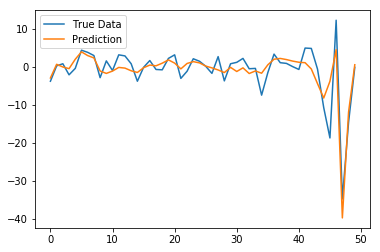

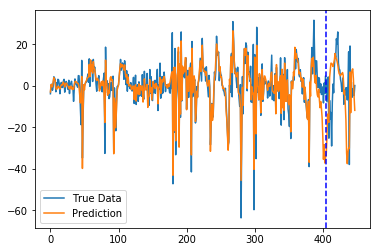

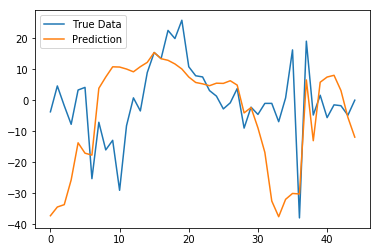

In [40]:
predicted = predict_point_by_point(model, X_test)        
predicted_train = predict_point_by_point(model, X_train)
print(predicted_train.shape)
print('Training duration (s) : ', time.time() - global_start_time)
plot_results(predicted_train[:50], y_train[:50], False)
plot_results(np.concatenate([predicted_train,predicted]), np.concatenate([y_train,y_test]), True)
plot_results(predicted[:50], y_test[:50], False)

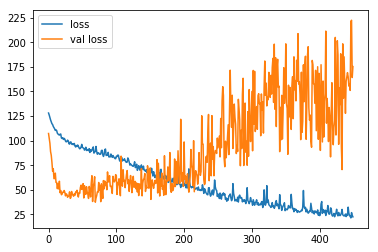

In [39]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(range(len(history.losses)),history.losses, label='loss')
plt.plot(range(len(history.val_losses)),history.val_losses, label='val loss') 
plt.legend()
plt.show()

In [ ]:
predicted = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
predicted_train = lstm.predict_sequences_multiple(model, X_train, seq_len, 50)
plot_results(predicted_train[:50], y_train[:50], False)
plot_results(np.concatenate([predicted_train,predicted]), np.concatenate([y_train,y_test]), True)
plot_results_multiple(predicted[:50], y_test[:50], 50, False)

In [ ]:
predicted = lstm.predict_sequence_full(model, X_test, seq_len)
predicted_train = lstm.predict_sequence_full(model, X_train, seq_len)